In [16]:
import os
import random
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Load & Preprocess Text Data

In [17]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            label_id = 0 if label == "neg" else 1
            examples.append({"sentence": sentence, "label": label_id})
    return pd.DataFrame(examples)


folder_paths_text = {
    "train": "./data/ntc-scv/data_train/train/",
    "valid": "./data/ntc-scv/data_train/test/",
    "test": "./data/ntc-scv/data_test/test/",
}

train_df = load_data_from_path(folder_paths_text["train"])
valid_df = load_data_from_path(folder_paths_text["valid"])
test_df = load_data_from_path(folder_paths_text["test"])

print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")


Train: 30000, Valid: 10000, Test: 10000


### Text Preprocessing

In [18]:
import re
import string


def preprocess_text(text):
    # Remove URL
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    text = url_pattern.sub(r" ", text)

    # Remove HTML Tag
    htlm_pattern = re.compile(r"<[^<>]+>")
    text = htlm_pattern.sub(" ", text)

    # Remove punctuation and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # Remove emoji
    emoji_pattern = re.compile(
        "["
        "\U0001f600-\U0001f64f"
        "\U0001f300-\U0001f5ff"
        "\U0001f680-\U0001f6ff"
        "\U0001f1e0-\U0001f1ff"
        "\U0001f1f2-\U0001f1f4"
        "\U0001f1e6-\U0001f1ff"
        "\U0001f600-\U0001f64f"
        "\U00002702-\U000027b0"
        "\U000024c2-\U0001f251"
        "\U0001f926-\U0001f937"
        "\U0001f1f2"
        "\U0001f1f4"
        "\U0001f620"
        "\u200d"
        "\u2640-\u2642"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub(r" ", text)

    # Normalize whitespace and lowercase
    text = " ".join(text.split()).lower()
    return text

In [19]:
# Apply preprocessing
train_df["preprocess_sentence"] = train_df["sentence"].apply(preprocess_text)
valid_df["preprocess_sentence"] = valid_df["sentence"].apply(preprocess_text)
test_df["preprocess_sentence"] = test_df["sentence"].apply(preprocess_text)

### Build Vocabulary

In [ ]:
from collections import Counter


# Simple tokenizer: split by space
def simple_tokenizer(text):
    return text.split()


# Build vocabulary
def build_vocab(texts, max_vocab_size=10000):
    word_freq = Counter()
    for text in texts:
        tokens = simple_tokenizer(text)
        word_freq.update(tokens)

    # Get most common words
    most_common = word_freq.most_common(max_vocab_size - 2)  # -2 for <pad> and <unk>

    # Create word to index mapping
    word2idx = {"<pad>": 0, "<unk>": 1}
    for idx, (word, fred) in enumerate(most_common, start=2):
        word2idx[word] = idx
    return word2idx


# Encode function
def encode_text(text, word2idx):
    tokens = simple_tokenizer(text)
    return [word2idx.get(token, word2idx["<unk>"]) for token in tokens]


# Build vocabulary from training data
word2idx = build_vocab(train_df["preprocess_sentence"], max_vocab_size=10000)
vocab_size = len(word2idx)

print(f"Vocabulary size: {vocab_size}")
print(f"Sample words: {list(word2idx.items())[:10]}")

Vocabulary size: 10000
Sample words: [('<pad>', 0), ('<unk>', 1), ('ăn', 2), ('mình', 3), ('có', 4), ('là', 5), ('không', 6), ('quán', 7), ('thì', 8), ('và', 9)]


### Create dataset & dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, df, word2idx):
        self.texts = df["preprocess_sentence"].values
        self.labels = df["label"].values
        self.word2idx = word2idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = encode_text(self.texts[idx], self.word2idx)
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(
            self.labels[idx], dtype=torch.long
        )


# Collate function for batching
def collate_batch(batch):
    encoded_sentences, labels = [], []
    for encoded, label in batch:
        encoded_sentences.append(encoded)
        labels.append(label)

    # Pad sequences
    encoded_sentences = pad_sequence(encoded_sentences, padding_value=word2idx["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)

    return encoded_sentences, labels


# Create datasets
text_train_dataset = TextDataset(train_df, word2idx)
text_valid_dataset = TextDataset(valid_df, word2idx)
text_test_dataset = TextDataset(test_df, word2idx)

# Create dataloaders
batch_size = 128
text_train_dataloader = DataLoader(
    text_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
text_valid_dataloader = DataLoader(
    text_valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)
text_test_dataloader = DataLoader(
    text_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

print(
    f"Train dataset: {len(text_train_dataset)}, Valid dataset: {len(text_valid_dataset)}, Test dataset: {len(text_test_dataset)}"
)
print(
    f"Number of batches - Train: {len(text_train_dataloader)}, Valid: {len(text_valid_dataloader)}, Test: {len(text_test_dataloader)}"
)


Train dataset: 30000, Valid dataset: 10000, Test dataset: 10000
Number of batches - Train: 235, Valid: 79, Test: 79


### Define Text CNN Model

In [ ]:
class TextCNN(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes
    ):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=embedding_dim,
                    out_channels=num_filters,
                    kernel_size=k,
                    stride=1,
                )
                for k in kernel_sizes
            ]
        )
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        # x shape: (seq_len, batch_size)
        x = self.embedding(x.T).transpose(1, 2)  # (batch_size, embedding_dim, seq_len)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x


### Training and Evaluation Function

In [ ]:
def train(
    model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50
):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            print(
                f"| epoch {epoch:3d} | {idx:5d}/{len(train_dataloader):5d} batches | accuracy {total_acc / total_count:8.3f}"
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count if total_count > 0 else 0
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


In [ ]:
# Model setup
embedding_dim = 100
# vocab_size = len(word2idx)

text_model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2,
).to(device)

print(f"Text Model initialized on {device}")
print(f"Vocab size: {vocab_size}, Embedding dim: {embedding_dim}")
print(f"Total parameters: {sum(p.numel() for p in text_model.parameters()):,}")

criterion_text = nn.CrossEntropyLoss()
optimizer_text = optim.Adam(text_model.parameters())

# Training loop
num_epochs = 4
save_model = "./model"
os.makedirs(save_model, exist_ok=True)

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(
        text_model,
        optimizer_text,
        criterion_text,
        text_train_dataloader,
        device,
        epoch,
        log_interval=50,
    )
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(
        text_model, criterion_text, text_valid_dataloader, device
    )
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(
            text_model.state_dict(), os.path.join(save_model, "text_cnn_model.pt")
        )

    # Print results
    print("-" * 80)
    print(
        f"| End of epoch {epoch:3d} | Time: {time.time() - epoch_start_time:5.2f}s | "
        f"Train Acc: {train_acc:8.3f} | Train Loss: {train_loss:8.3f} | "
        f"Valid Acc: {eval_acc:8.3f} | Valid Loss: {eval_loss:8.3f} |"
    )
    print("-" * 80)

# Load best model
text_model.load_state_dict(
    torch.load(os.path.join(save_model, "text_cnn_model.pt"), weights_only=True)
)
text_model.eval()


Text Model initialized on mps
Vocab size: 10000, Embedding dim: 100
Total parameters: 1,120,902
| epoch   1 |    50/  235 batches | accuracy    0.733
| epoch   1 |   100/  235 batches | accuracy    0.839
| epoch   1 |   150/  235 batches | accuracy    0.868
| epoch   1 |   200/  235 batches | accuracy    0.863
--------------------------------------------------------------------------------
| End of epoch   1 | Time: 12.34s | Train Acc:    0.876 | Train Loss:    0.385 | Valid Acc:    0.875 | Valid Loss:    0.314 |
--------------------------------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.916
| epoch   2 |   100/  235 batches | accuracy    0.919
| epoch   2 |   150/  235 batches | accuracy    0.920
| epoch   2 |   200/  235 batches | accuracy    0.908
--------------------------------------------------------------------------------
| End of epoch   2 | Time: 12.82s | Train Acc:    0.908 | Train Loss:    0.232 | Valid Acc:    0.880 | 

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

### Plot training results

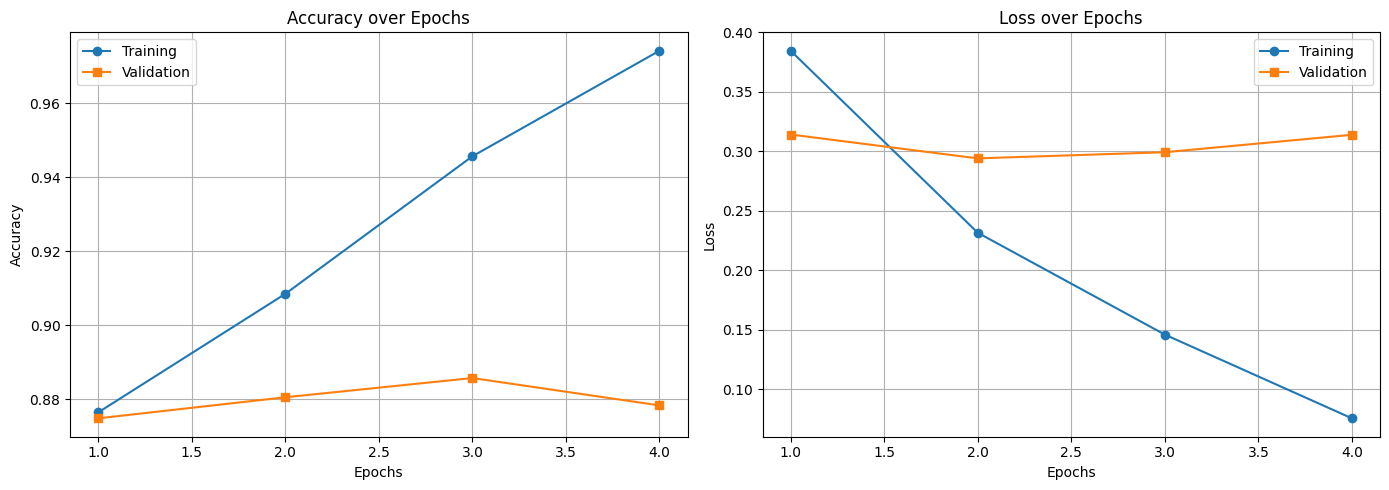

In [25]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(1, num_epochs + 1))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    axs[0].plot(epochs, train_accs, label="Training", marker="o")
    axs[0].plot(epochs, eval_accs, label="Validation", marker="s")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy over Epochs")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs, train_losses, label="Training", marker="o")
    axs[1].plot(epochs, eval_losses, label="Validation", marker="s")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].set_title("Loss over Epochs")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)


In [26]:
test_acc, test_loss = evaluate(text_model, criterion_text, text_test_dataloader, device)
print(f"Text Classification Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Text Classification Test Accuracy: 0.8903, Test Loss: 0.2740


In [ ]:
def inference_text(sentence, word2idx, model, device):
    """Predict sentiment of a given sentence"""
    preprocessed = preprocess_text(sentence)
    encoded_sentence = encode_text(preprocessed, word2idx)
    encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.long)
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(encoded_sentence)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)

    sentiment = "Positive" if yhat.item() == 1 else "Negative"
    confidence = round(p_max.item() * 100, 2)

    return sentiment, confidence


# Test inference
test_sentences = [
    # Positive
    "Sản phẩm rất tốt, tôi rất hài lòng!",
    "Giao hàng nhanh, đóng gói cẩn thận.",
    # Negative
    "Chất lượng tệ, không đáng tiền.",
    "Sản phẩm bị hỏng, dịch vụ hỗ trợ rất chậm.",
    "Màu sắc khác hoàn toàn so với hình, tôi rất thất vọng.",
]


for sentence in test_sentences:
    sentiment, confidence = inference_text(sentence, word2idx, text_model, device)
    print(f"Sentence: {sentence}")
    print(f"Sentiment: {sentiment}, Confidence: {confidence}%")
    print("-" * 50)


Sentence: Sản phẩm rất tốt, tôi rất hài lòng!
Sentiment: Positive, Confidence: 98.13%
--------------------------------------------------
Sentence: Giao hàng nhanh, đóng gói cẩn thận.
Sentiment: Positive, Confidence: 86.0%
--------------------------------------------------
Sentence: Chất lượng tệ, không đáng tiền.
Sentiment: Negative, Confidence: 99.11%
--------------------------------------------------
Sentence: Sản phẩm bị hỏng, dịch vụ hỗ trợ rất chậm.
Sentiment: Negative, Confidence: 94.22%
--------------------------------------------------
Sentence: Màu sắc khác hoàn toàn so với hình, tôi rất thất vọng.
Sentiment: Negative, Confidence: 95.98%
--------------------------------------------------
